In [1]:
import time
import numpy as np
import networkx as nx
from utils.dotdict import dotdict
import matplotlib.pyplot as plt
from numba import jit

import itertools
import multiprocessing

from utils.graph_generator import get_graph
from utils.params import init_graph, get_centrum
from utils.params import GIRG_args1,GIRG_args2,GIRG_args3,GIRG_args4, get_moving

from scripts.awareness.agent_country import Agent_Country

In [2]:
args = dotdict({
    "logfile": "log/GIRG.log",
    "plot": False,
    "max_iteration": 1000,
    "beta_super":0.0,
    "xi": 1,
    "p_teleport":0.0,
    "MAX_E_TIME":10,
    "MAX_I_TIME":10,
    "super_infected_agents": [],
    "p_super": 0.0,
    "awM": None,
    "awR": -1,
    "random_seed":0,
    "CPU_cores":15,
    "simnum":10,
})

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def pos_in_rectangle(pos, rect):
    return pos[0]>=rect[0] and pos[0]<=rect[1] and pos[1]>=rect[2] and pos[1]<=rect[3]

def get_diam(country, graph):
    Is = np.arange(len(graph))[country.states==2]
    #print(Is, graph.nodes)
    Is = [n for i,n in enumerate(graph.nodes) if country.states[i]==2]
    g = graph.subgraph(Is)
    
    nodes = sorted(nx.connected_components(g), key=len, reverse=True)[0]
    g = g.subgraph(nodes)

    ps = np.array(list(nx.get_node_attributes(g, 'pos').values()))
    #print(ps, ps.shape)
    pos = nx.get_node_attributes(graph, 'pos')
    rect = [np.min(ps[:,0]), np.max(ps[:,0]), np.min(ps[:,1]), np.max(ps[:,1])]
    Inf_rect = [n for i,n in enumerate(graph.nodes) if country.states[i]==2 and pos_in_rectangle(pos[n],rect)]
    
    #return np.array([nx.diameter(g), len(nodes), len(Inf_rect)/((rect[1]-rect[0]+1)*(rect[3]-rect[2]+1))])
    return np.array([nx.diameter(g), len(nodes), len(nodes)/((rect[1]-rect[0]+1)*(rect[3]-rect[2]+1))])

def run(args, graph, inf, beta, gamma, n, awM, random_seed=0):
    args = dotdict(args)
    
    args["I_time"]=int(1/gamma)
    args["infected_agents"]=inf
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM


    res = np.zeros(shape=(args["max_iteration"], 4))
    agents = np.zeros(shape=(args["max_iteration"], len(graph)))
    diams = np.zeros(shape=(args["max_iteration"], 3))

    country = Agent_Country(args, graph)
    country.init_seeds = args["infected_agents"]
    Agent_Country.numba_random_seed(random_seed)
    country.log_json()
    for i in range(args["max_iteration"]):
        res[i,2]=np.sum(country.states ==2)
        #diams[i,:] = get_diam(country, graph)
        agents[i] += country.states ==2
        
        if country.check_stop():
            #break
            pass
        country.step()
        country.log_json()

    return res[:i,2], agents

In [4]:
def plot_kcore_and_I_correlation(graph, A, title):
    plt.figure(figsize=(15,4))

    k_num = nx.algorithms.core.core_number(graph)

    x = np.array([k_num[n] for n in graph.nodes])
    y = np.array([A[n] for n in graph.nodes])
    plt.scatter(x,y)
    plt.xlabel("k-core")
    plt.ylabel("Infection probability")
    plt.title(title)
    plt.show()
    
    max_k = np.max(list(k_num.values()))+1
    x_core = np.array(range(1,max_k))
    y_new=[np.mean(np.extract(x==i, y)) for i in x_core]
    y_err = [np.std(np.extract(x==i, y)) for i in x_core]

    plt.figure(figsize=(15,4))
    plt.xlabel("k-core")
    plt.ylabel("Infection probability")
    plt.errorbar(x_core,y_new, yerr=y_err, c="r")
    plt.title(title)
    plt.show()
    
def plot_deg_and_I_correlation(graph, A, title):
    deg = dict(nx.degree(graph))
    deg_nodes = np.array(sorted(deg.items(), key=lambda l:l[1]))

    deg_I = [A[n] for n in deg_nodes[:,0]]
    
    plt.figure(figsize=(15,4))
    plt.scatter(deg_nodes[:,1],deg_I)
    plt.xlabel("degree")
    plt.ylabel("Infected probability")
    plt.title(title)
    plt.show()

In [5]:
GIRG_args = GIRG_args1
GIRG_args["config_model"]=False
GIRG_args["random_seed"]=0
graph = init_graph(GIRG_args)
centrum = get_centrum(graph, "k-core", len(graph))
inf = centrum[:10]

args["max_iteration"] = 10000
Is, agents = run(args, graph, inf, 0.6, 0.3, -1, 0.1)

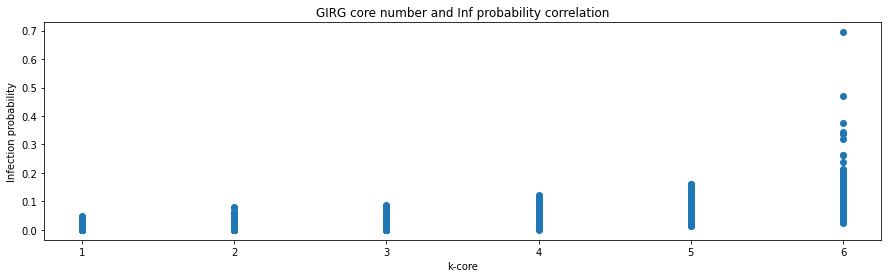

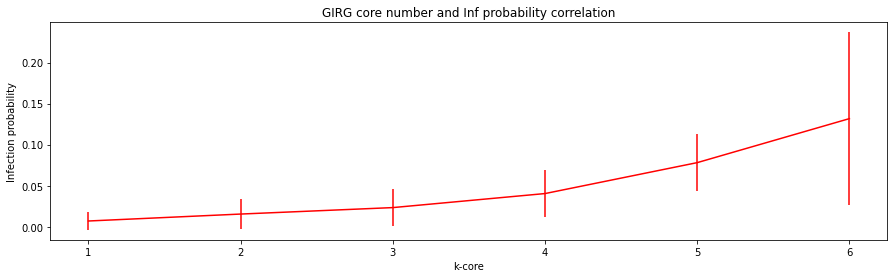

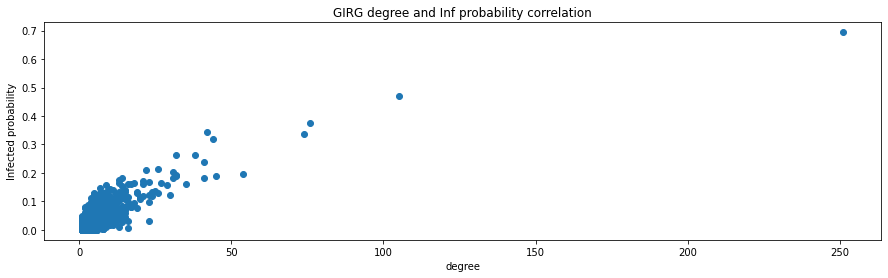

In [6]:
A0 = np.mean(agents, axis=0)
plot_kcore_and_I_correlation(graph, A0, title="GIRG core number and Inf probability correlation")
plot_deg_and_I_correlation(graph, A0, "GIRG degree and Inf probability correlation")

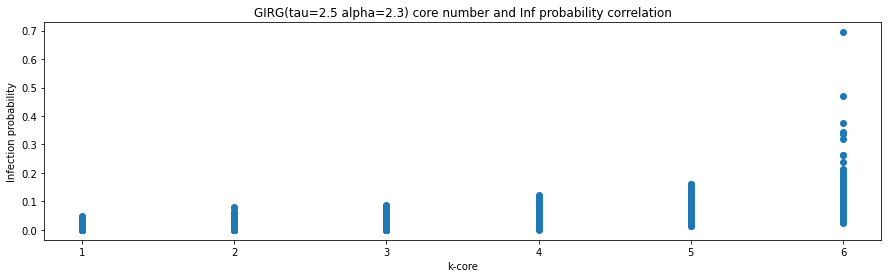

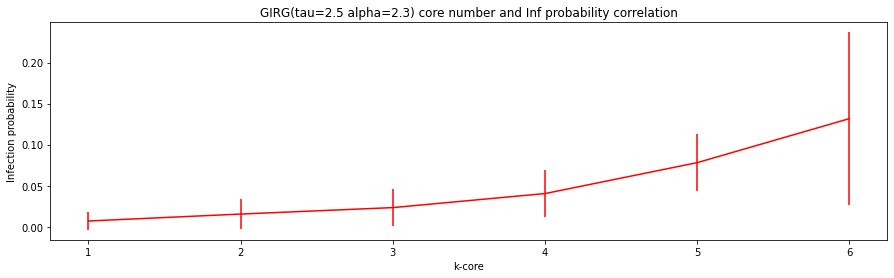

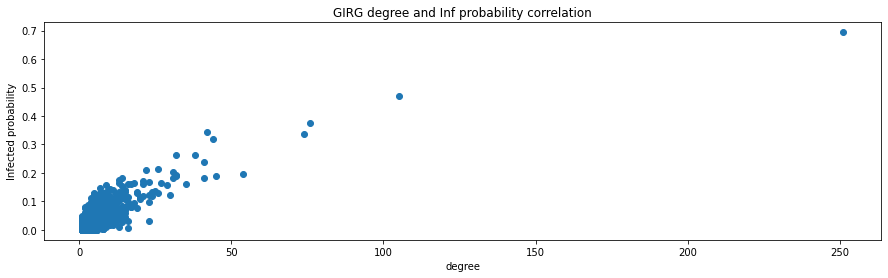

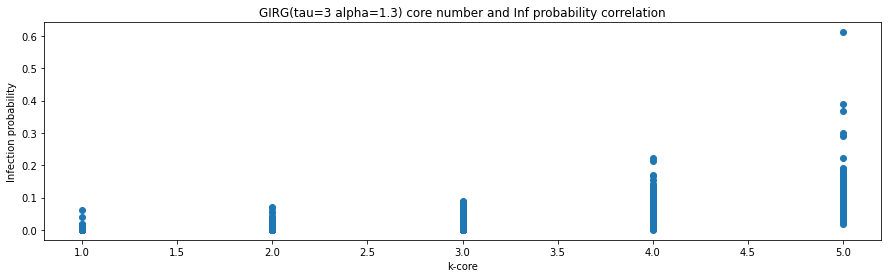

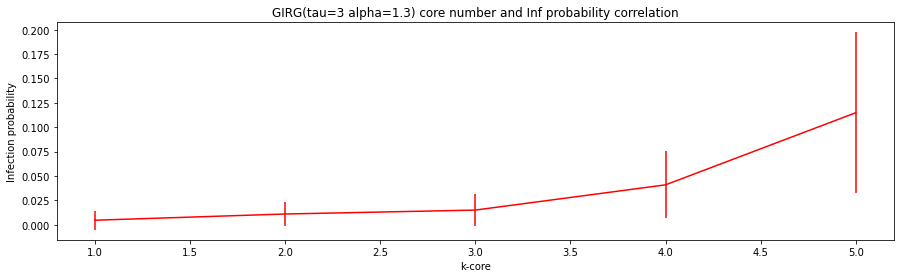

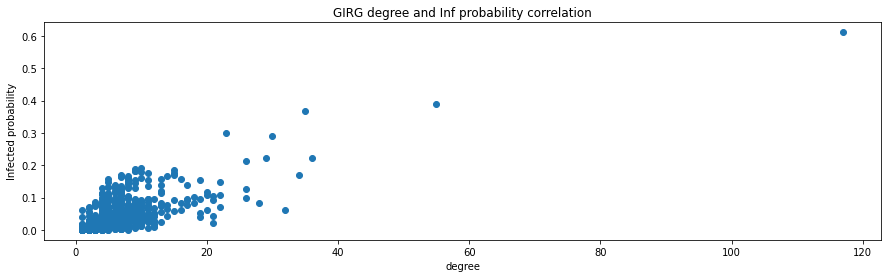

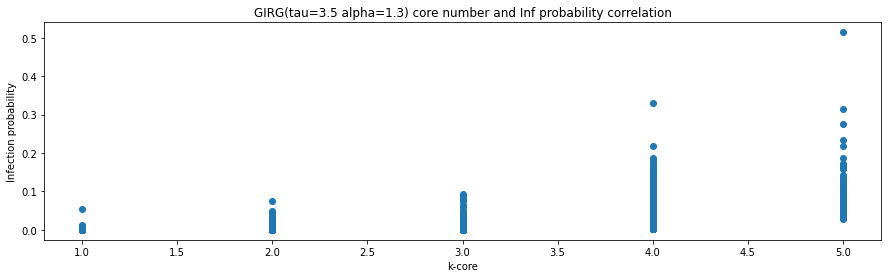

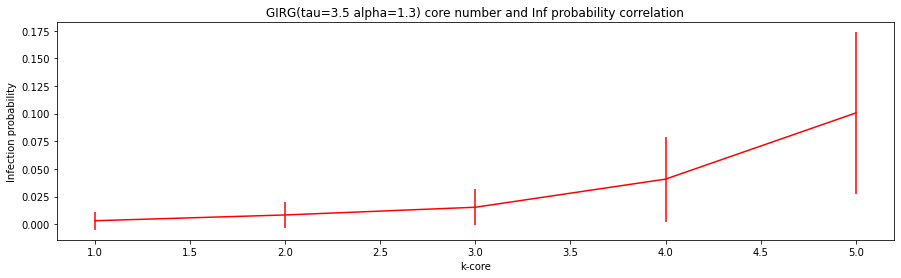

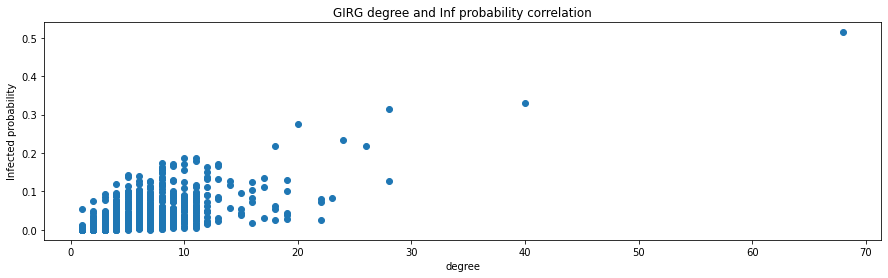

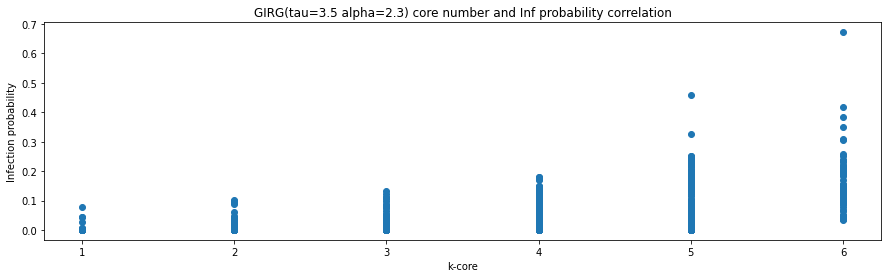

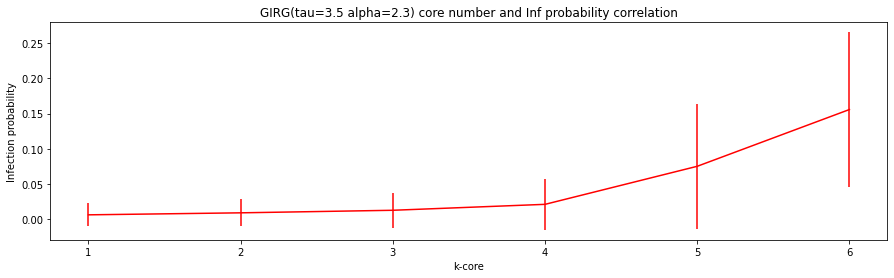

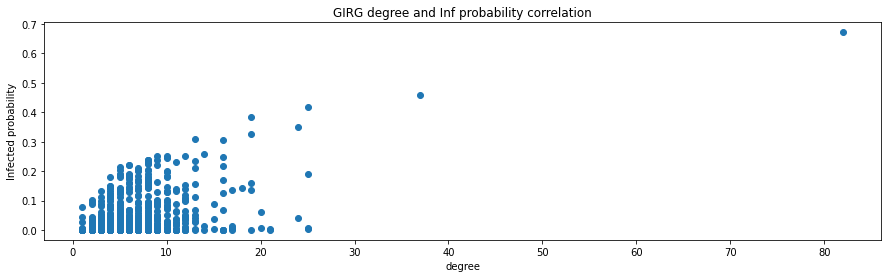

In [8]:
GIRG_res = {}
for GIRG_args in [GIRG_args1, GIRG_args2, GIRG_args3, GIRG_args4]:
    tau = GIRG_args["tau"]
    alpha = GIRG_args["alpha"]
    
    GIRG_args["config_model"]=False
    GIRG_args["random_seed"]=0
    graph = init_graph(GIRG_args)
    centrum = get_centrum(graph, "k-core", len(graph))
    inf = centrum[:10]

    args["max_iteration"] = 10000
    Is, agents = run(args, graph, inf, 0.6, 0.3, -1, 0.1)
    
    A1 = np.mean(agents, axis=0)
    plot_kcore_and_I_correlation(graph, A1, title=f"GIRG(tau={tau} alpha={alpha}) core number and Inf probability correlation")
    plot_deg_and_I_correlation(graph, A1, "GIRG degree and Inf probability correlation")
    
    GIRG_res[GIRG_args]=A1
    print(len(GIRG_res))

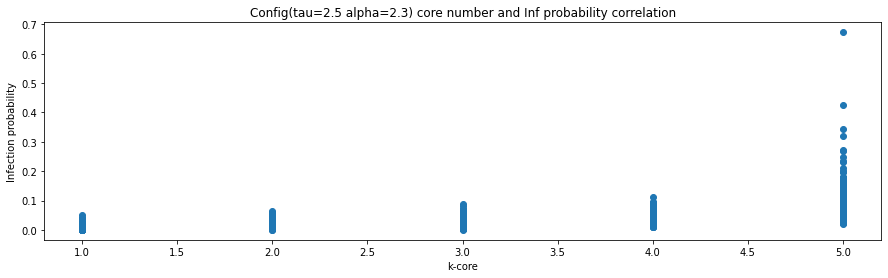

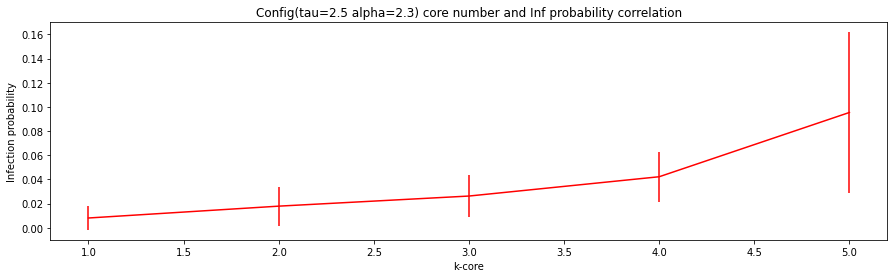

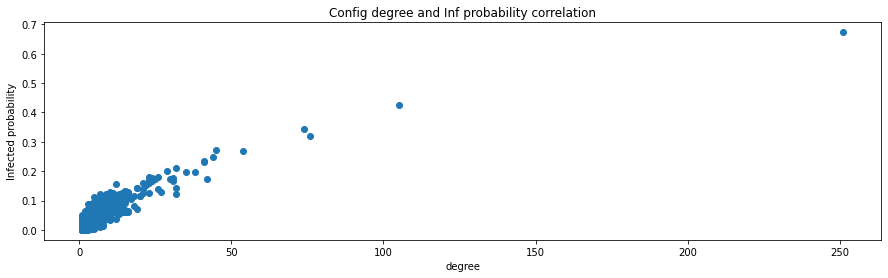

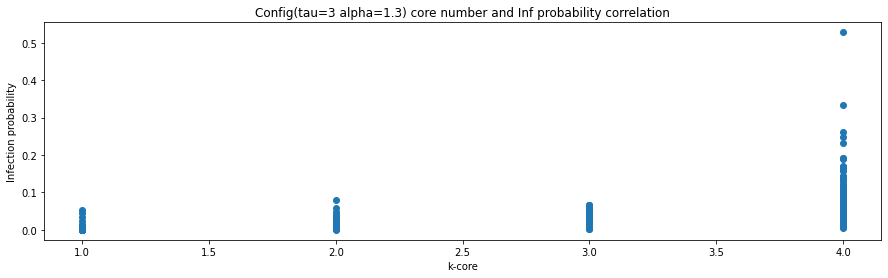

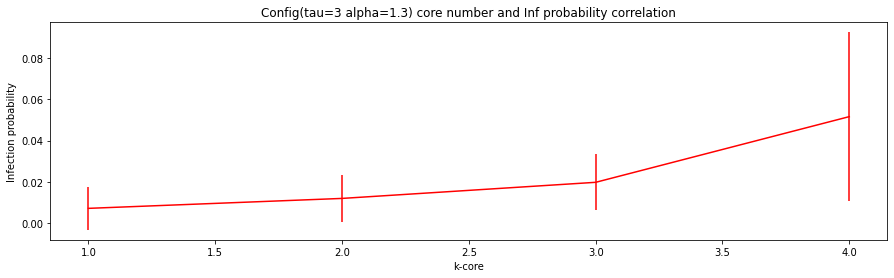

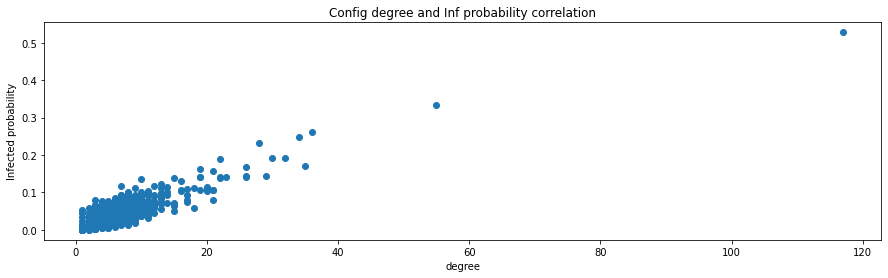

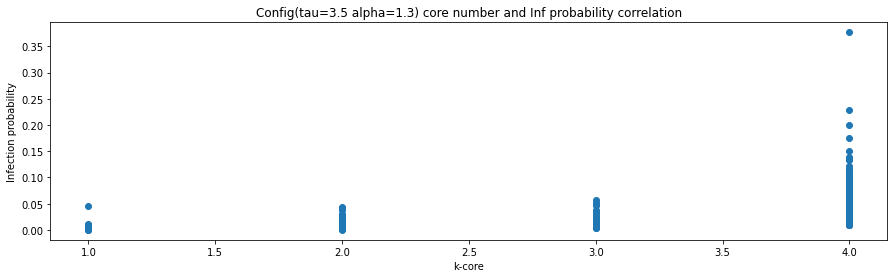

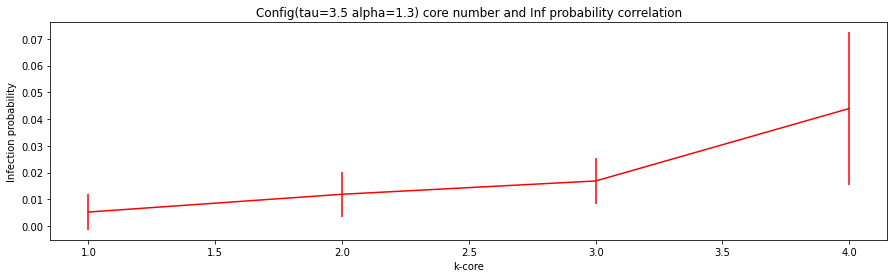

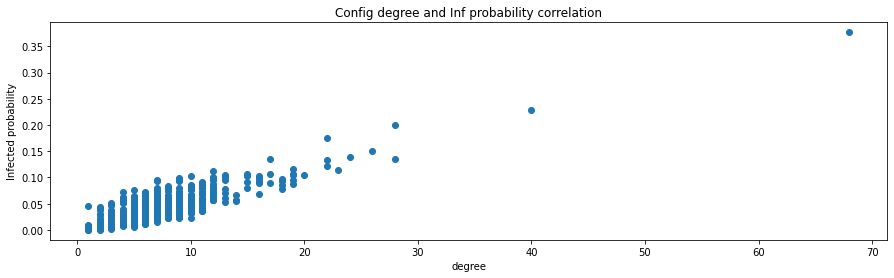

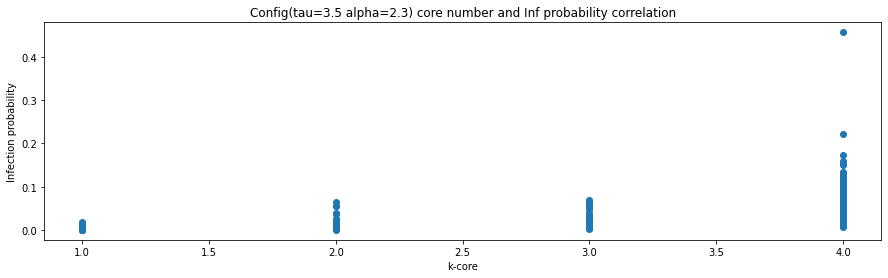

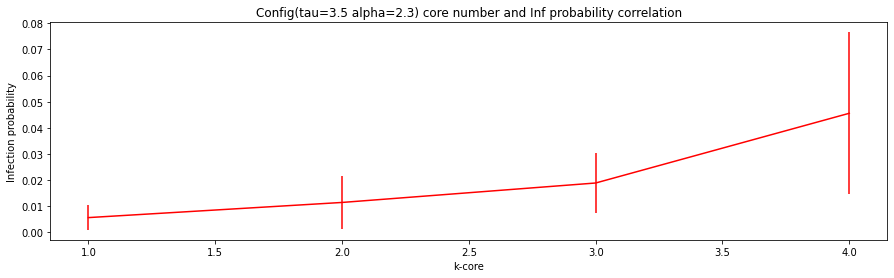

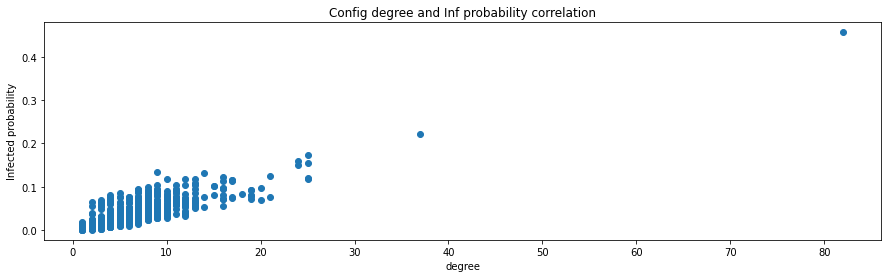

In [10]:
config_res = {}

for GIRG_args in [GIRG_args1, GIRG_args2, GIRG_args3, GIRG_args4]:
    tau = GIRG_args["tau"]
    alpha = GIRG_args["alpha"]
    
    GIRG_args["config_model"]=True
    GIRG_args["random_seed"]=0
    graph = init_graph(GIRG_args)
    centrum = get_centrum(graph, "k-core", len(graph))
    inf = centrum[:10]

    args["max_iteration"] = 10000
    Is, agents = run(args, graph, inf, 0.6, 0.3, -1, 0.1)
    
    A1 = np.mean(agents, axis=0)
    plot_kcore_and_I_correlation(graph, A1, title=f"Config(tau={tau} alpha={alpha}) core number and Inf probability correlation")
    plot_deg_and_I_correlation(graph, A1, "Config degree and Inf probability correlation")

    config_res[GIRG_args]=A1
    print(len(GIRG_res))

In [11]:
GIRG_args = GIRG_args1
GIRG_args["config_model"]=False
GIRG_args["random_seed"]=0
graph = init_graph(GIRG_args)
centrum = get_centrum(graph, "k-core", len(graph))
inf = centrum[:10]

args["max_iteration"] = 10000
Is, agents = run(args, graph, inf, 0.15, 0.3, -1, 0.0)

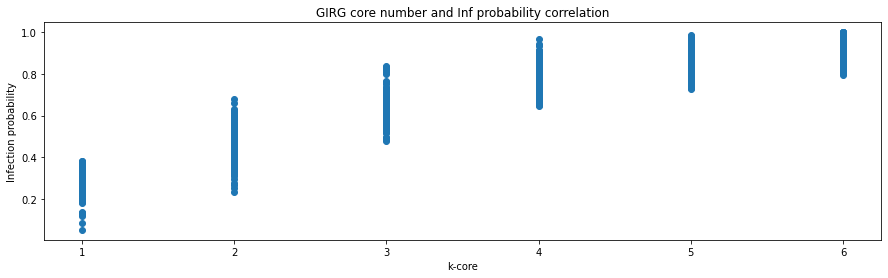

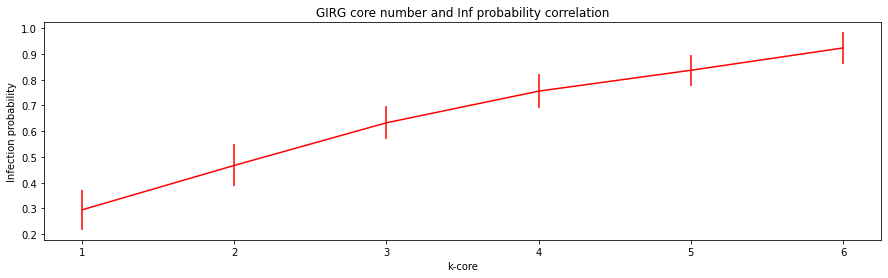

In [12]:
A2 = np.mean(agents, axis=0)
plot_kcore_and_I_correlation(graph, A2, title="GIRG core number and Inf probability correlation")